In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
from keras.models import load_model
from layers import BilinearUpSampling2D
from loss import depth_loss_function
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np
from PIL import Image
import time

import glob
from skimage.transform import resize


In [4]:
def normalize(x):
    import numpy as np
    (654, 480, 640)
    normalized = (x-np.min(x))/(np.max(x)-np.min(x))
    normalized = np.clip(normalized, 0.001, 1, out=normalized)
    
    return normalized

def load_images(image_files):
    loaded_images = []
    for file in image_files:
        x = np.asarray(Image.open(file), dtype=float)
        loaded_images.append(x)
    return np.stack(loaded_images, axis=0)

def DepthNorm(x, maxDepth):
    return maxDepth / x

def predictue(model, images, minDepth=0, maxDepth=255, batch_size=2):
    # Support multiple RGBs, one RGB image, even grayscale 
    if len(images.shape) < 3: images = np.stack((images,images,images), axis=2)
    if len(images.shape) < 4: images = images.reshape((1, images.shape[0], images.shape[1], images.shape[2]))
    # Compute predictions
    predictions = model.predict(images, batch_size=batch_size)
    # Put in expected range
    return normalize(predictions)

def compute_errors(gt, pred):
    thresh = np.maximum((gt / pred), (pred / gt))
    a1 = (thresh < 1.25).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()
    abs_rel = np.mean(np.abs(gt - pred) / gt)
    rmse = (gt - pred) ** 2
    rmse = np.sqrt(rmse.mean())
    log_10 = (np.abs(np.log10(gt) - np.log10(pred))).mean()
    return a1, a2, a3, abs_rel, rmse, log_10

def evaluate_ue(model, rgb, depth, batch_size=6, minDepth=10, maxDepth = 1000, verbose=False):
    N = len(rgb)

    bs = batch_size

    predictions = []
    testSetDepths = []
    
    for i in range(N//bs):    
        x = rgb[(i)*bs:(i+1)*bs,:,:,:]
        
        # Compute results
        true_y = depth[(i)*bs:(i+1)*bs,:,:]
        pred_y = scale_up(2, predictue(model, x/255, minDepth=minDepth, maxDepth=maxDepth, batch_size=bs)[:,:,:,0])
        
        # Test time augmentation: mirror image estimate
        pred_y_flip = scale_up(2, predictue(model, x[...,::-1,:]/255, minDepth=minDepth, maxDepth=maxDepth, batch_size=bs)[:,:,:,0])

        
        # Compute errors per image in batch
        for j in range(len(true_y)):
            predictions.append(   (0.5 * pred_y[j]) + (0.5 * np.fliplr(pred_y_flip[j]))   )
            testSetDepths.append(   true_y[j]   )

    predictions = np.stack(predictions, axis=0)
    testSetDepths = np.stack(testSetDepths, axis=0)

    e = compute_errors(predictions, testSetDepths)

    if verbose:
        print("{:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}".format('a1', 'a2', 'a3', 'rel', 'rms', 'log_10'))
        print("{:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}".format(e[0],e[1],e[2],e[3],e[4],e[5]))

    return e

# Load Model

In [5]:
modelname = 'morse13k.h5'
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': depth_loss_function}
uemodel = load_model(modelname, custom_objects=custom_objects, compile=False)


# Load Data

In [9]:
import glob 

source = 'E:/Dataset/Dataset/Ablation/'
#source = './test_data/same_domain/'
depthlist = glob.glob(source + 'Depth/*_final.png')
rgblist = glob.glob(source + 'Same_domain/*_final.png')

uedepth = load_images(depthlist)
uergb = load_images(rgblist)

# Compute Score

In [10]:
count = 0
scoreaverage = []
for i, (img, label) in enumerate(zip(uergb, uedepth)):
    
    pred = predictue(uemodel, img).squeeze()
    scaled = resize(pred, (480,640), order=1, preserve_range=True, mode='reflect', anti_aliasing=True)
    error = compute_errors(label,scaled)
    if error[0] > 0 : 
        count+=1
        scoreaverage.append(error)
        print(i, end='\r')
        
scoreaverage = np.array(scoreaverage)
print(scoreaverage.mean(0))
print(count)

C:\Users\Mehdi\AppData\Local\conda\conda\envs\tensor\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice.
  


nan
0


C:\Users\Mehdi\AppData\Local\conda\conda\envs\tensor\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


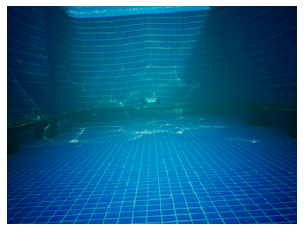

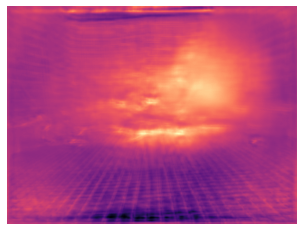

In [11]:
plt.axis('off')
plt.imshow(img/255, cmap='magma')
plt.show()
plt.axis('off')
plt.imshow(scaled, cmap='magma')
plt.show()

In [ ]:
np.asarray(Image.open(depthlist[1])).max()

In [ ]:
pred.max()